In [1]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [2]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    './data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


normalizing counts per cell
    finished (0:00:00)


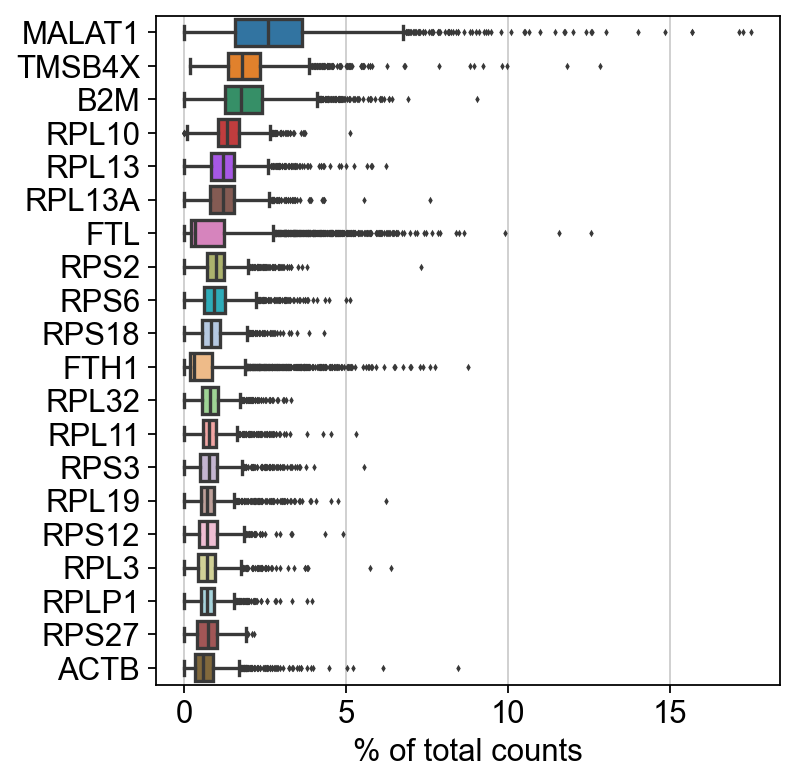

In [3]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [4]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


filtered out 19024 genes that are detected in less than 3 cells


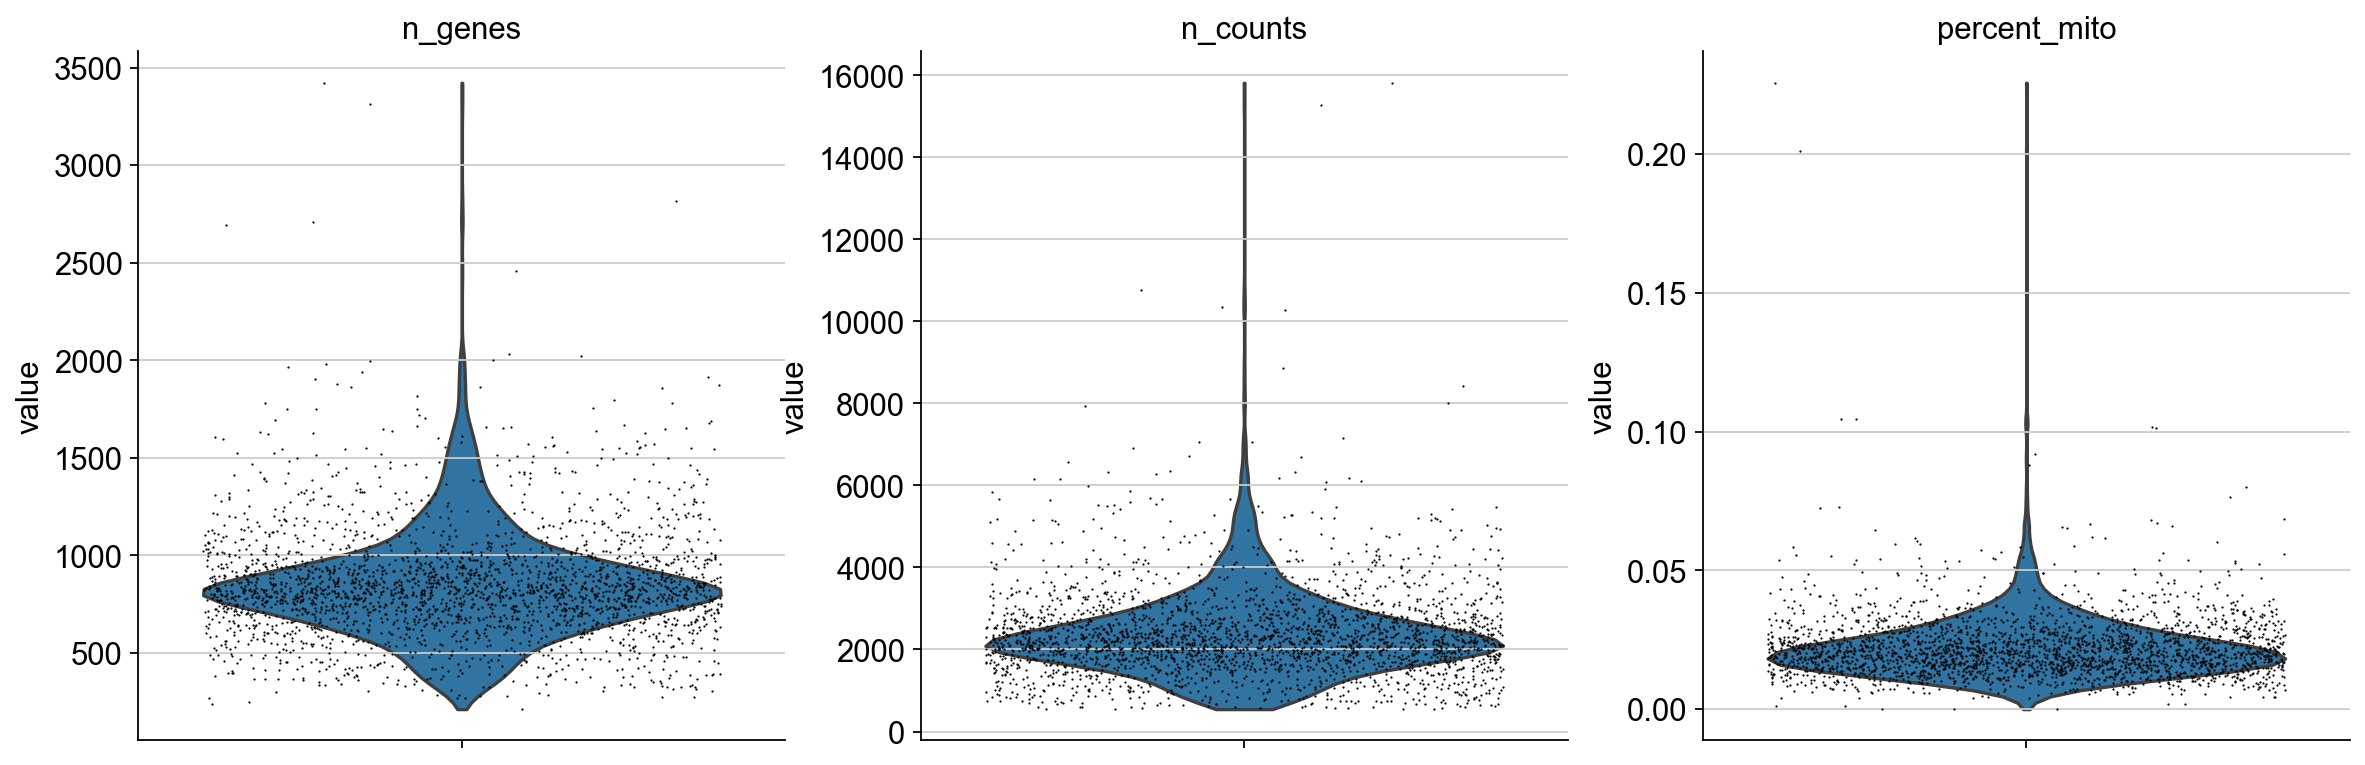

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [5]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [6]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)


normalizing counts per cell


    finished (0:00:00)


In [7]:
# Store the raw data
adata.raw = adata


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


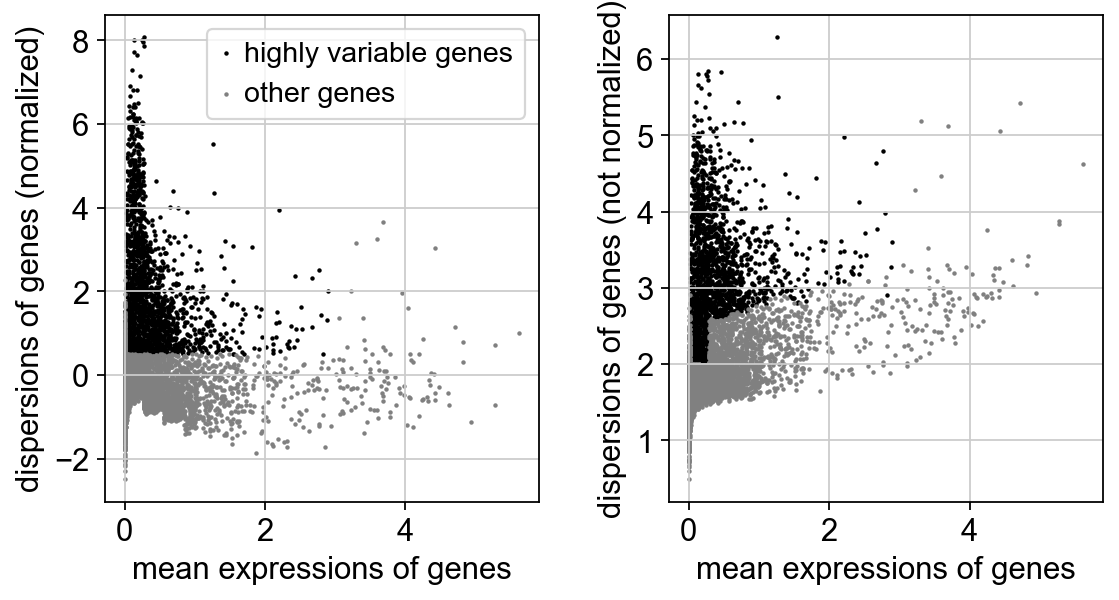

1838


In [8]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


In [9]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Dimension Reduction

### Simlr

In [10]:
# # If SIMLR is not installed in R, you can install it using the following R commands:
# # Initialize R instance
# import rpy2.robjects as robjects
# r = robjects.r

# # Install BiocManager directly using R
# r('install.packages("BiocManager", repos="http://cran.us.r-project.org")')
# r('BiocManager::install()')

# # Now, try installing simlr package
# r('BiocManager::install("SIMLR")')

In [11]:
# Import R packages
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.vectors import DataFrame


In [12]:
# Activate the pandas2ri interface
pandas2ri.activate()

# Convert the AnnData to a DataFrame for the count data
with localconverter(robjects.default_converter + pandas2ri.converter):
    df = adata.to_df()

df_transposed = df.T

In [13]:
# Convert the Pandas DataFrame to an R data frame
with localconverter(robjects.default_converter + pandas2ri.converter):
    count_data_r = robjects.conversion.py2rpy(df_transposed)


In [14]:
nrows = robjects.r['nrow'](count_data_r)[0]
ncols = robjects.r['ncol'](count_data_r)[0]
print(f"Shape of DataFrame: ({nrows}, {ncols})")

Shape of DataFrame: (1838, 2638)


In [15]:
# Load the SIMLR library in R
robjects.r('library(SIMLR)')

# Run SIMLR on the count data
# or SIMLR, set K equal to the expected number of clusters
K = 10  # for example
simlr_result = robjects.r('SIMLR(%s, %d)' % (count_data_r.r_repr(), K))

# Check if the SIMLR result
print(simlr_result.names)




Computing the multiple Kernels.
Performing network diffiusion.
Iteration:  1 
Iteration:  2 
Iteration:  3 
Iteration:  4 
Iteration:  5 


In [ ]:
from rpy2.robjects.conversion import localconverter

# Retrieve the low-dimensional representation and clusters
with localconverter(robjects.default_converter + pandas2ri.converter):
    F = robjects.conversion.rpy2py(simlr_result.rx2('F'))
    clusters = robjects.conversion.rpy2py(simlr_result.rx2('ydata'))
    S = robjects.conversion.rpy2py(simlr_result.rx2('S'))


In [ ]:
# Check the contents of F and clusters
print("Shape of F:", F.shape)
print("Shape of clusters:", clusters.shape)


Shape of F: (1838, 10)
Shape of clusters: (1838, 2)


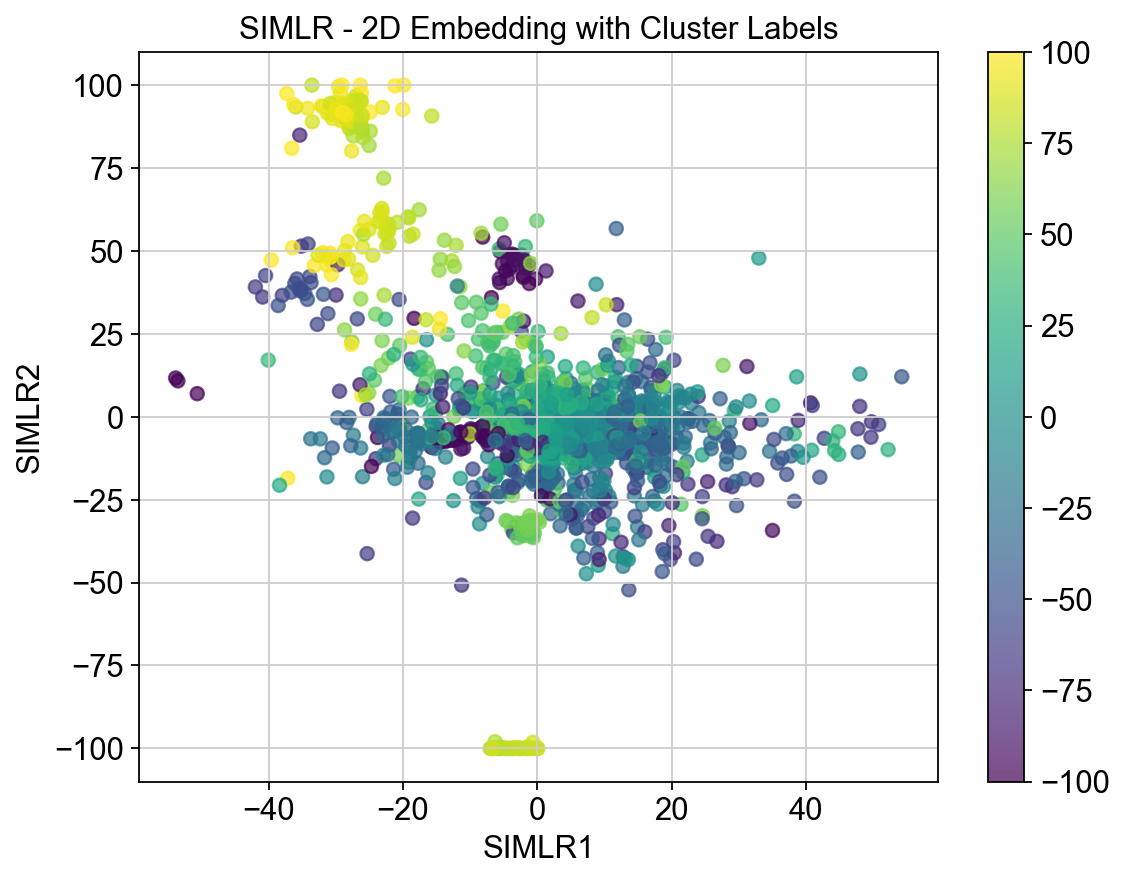

In [ ]:
# Visualize the results
# Assuming the first column of 'clusters' contains the cluster labels
cluster_labels = clusters[:, 0]

# Visualize the SIMLR results
plt.figure(figsize=(8, 6))
plt.scatter(F[:, 0], F[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('SIMLR - 2D Embedding with Cluster Labels')
plt.xlabel('SIMLR1')
plt.ylabel('SIMLR2')
plt.colorbar()
plt.show()



In [ ]:
# Transpose the F matrix and cluster labels
F_transposed = F.T
cluster_labels_transposed = cluster_labels.T


In [ ]:
# Add the F matrix and cluster labels to the AnnData object
adata.obsm['X_simlr'] = F_transposed
adata.obs['clusters'] = cluster_labels_transposed


AnnData object with n_obs × n_vars = 1838 × 10
    obs: 'clusters'

In [ ]:
# Save the AnnData object
adata_simlr.write('write/pbmc3k_SIMLR.h5ad', compression='gzip')